# Grouping and aggregating data

Most of the time, in pandas, we use `.groupby()` to group and aggregate data. This is a function that splits your data into certain categories, and then performs an aggregation, transformation, or filtration to those categories. Today we will only be looking at `.groupby()` and aggregations, and how they can help us to analyse our data. We will also learn about `resample()` as an alternative, more concise way to group dates and times.

As always, let's start by reading the data:

In [1]:
import pandas as pd

In [2]:
# orders_cl.csv
url = "https://drive.google.com/file/d/1Tla62vfu__kCqvgypZyVt2S9VuC016yH/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orders_cl = pd.read_csv(path)

# orderlines_cl.csv
url = "https://drive.google.com/file/d/1OhtkQS2fwOYdzfd-qPh7im35iLc-L9TA/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orderlines_cl = pd.read_csv(path)

# products_cl.csv
url = "https://drive.google.com/file/d/1s7Lai4NSlsYjGEPg1QSOUJobNYVsZBOJ/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
products_cl = pd.read_csv(path)

# brands_cl.csv
url = "https://drive.google.com/file/d/1XGyabaa4mAkjixMk3XPgx_14OoSse3rs/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
brands = pd.read_csv(path)

In [3]:
ol_df = orderlines_cl.copy()

In [4]:
ol_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216250 entries, 0 to 216249
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                216250 non-null  int64  
 1   id_order          216250 non-null  int64  
 2   product_id        216250 non-null  int64  
 3   product_quantity  216250 non-null  int64  
 4   sku               216250 non-null  object 
 5   unit_price        216250 non-null  float64
 6   date              216250 non-null  object 
dtypes: float64(1), int64(4), object(2)
memory usage: 11.5+ MB


Change `date` to datetime.

In [5]:
ol_df["date"] = pd.to_datetime(ol_df["date"])

## 1.&nbsp; `.groupby` a single feature

When we use the `.groupby()` method, we always state in the parentheses the name of the column that contains the categories that should be grouped. For example, we are grouping here by the product number (SKU), which will give us one line per sku. `.count()` will tell us how many rows have been condensed into each group.

In [6]:
ol_df.groupby("sku").count()

,id,id_order,product_id,product_quantity,unit_price,date
sku,,,,,,
8MO0001-A,2,2,2,2,2,2
8MO0003-A,3,3,3,3,3,3
8MO0007,29,29,29,29,29,29
8MO0008,30,30,30,30,30,30
8MO0009,28,28,28,28,28,28
...,...,...,...,...,...,...
ZAG0041,2,2,2,2,2,2
ZAG0042,1,1,1,1,1,1
ZEP0007,5,5,5,5,5,5


Notice how in this "grouped" DataFrame we have 6798 rows: one row for each unique `sku`. In the original DataFrame we had many more rows:

In [7]:
ol_df.shape

(216250, 7)

As you can see above, the same number of rows were condensed for each column, this is to be expected when we use `count()` as the aggregation function. However, if we use an aggregate such as `.sum()`, then we get the total for the condensed values of each column:

In [8]:
# here we use numeric=true as ol_df contains a datetime column, which is excluded by using this parameter
# by default numeric_only = False

ol_df.groupby("sku").sum(numeric_only=True)

,id,id_order,product_id,product_quantity,unit_price
sku,,,,,
8MO0001-A,2731953,813237,0,2,25.92
8MO0003-A,4893267,1557627,0,3,38.55
8MO0007,37205508,10794389,0,30,619.71
8MO0008,38188229,11034203,0,31,651.70
8MO0009,40281947,12270595,0,30,499.60
...,...,...,...,...,...
ZAG0041,3289730,1050270,0,2,39.98
ZAG0042,1641159,523690,0,1,19.99
ZEP0007,6423489,1858331,0,5,685.59


Now, obviously, not all of the information above matters: it's not relevant what the sum of the `id`'s is. So, let's select the `product_quantity` and see how many units of each product were sold:

In [9]:
ol_df.groupby("sku")["product_quantity"].sum()

,product_quantity
sku,
8MO0001-A,2
8MO0003-A,3
8MO0007,30
8MO0008,31
8MO0009,30
...,...
ZAG0041,2
ZAG0042,1
ZEP0007,5


It can be useful sometimes to sort the values from highest to lowest. With the `.sum()` of `product_quantity` this will help us to see how many of each item we sold in order of quantity.

In [10]:
(
    ol_df
    .groupby("sku")["product_quantity"]
    .sum()
    .sort_values(ascending=False)
)

,product_quantity
sku,
APP1190,5576
APP0698,2337
WDT0183,1828
APP1922,1663
APP0927,1618
...,...
AKI0019-A,1
ADN0049-A,1
ADN0055,1


Or if you wish for only a certain number of the largest or smallest numbers, remember you can use `.nlargest()` or `.nsmallest()`

In [11]:
(
    ol_df
    .groupby("sku")["product_quantity"]
    .sum()
    .nlargest(5)
)

,product_quantity
sku,
APP1190,5576
APP0698,2337
WDT0183,1828
APP1922,1663
APP0927,1618


### 1.1.&nbsp; List of aggregates

It is possible to use many different aggregates besides just `.sum()` and `.count()`. A full list can be found [here](https://pandas.pydata.org/docs/reference/groupby.html), and below are a few of the most useful.

* `.count()` – Number of non-null observations
* `.sum()` – Sum of values
* `.mean()` – Mean of values
* `.median()` – Median of values
* `.min()` – Minimum
* `.max()` – Maximum
* `.std()` – Standard deviation

### 1.2.&nbsp; `.agg()`
We are not restricted to only using one aggregate at a time. We can use the `.agg()` method to see multiple aggregates at once.

#### 1.2.1.&nbsp; multiple aggregates for one column
Here we first `.groupby()` the `sku`'s, then take the column `product quantity`, and look at both the `.sum()` and `.count()` of `product_quantity`. We also here reduced our DataFrame to the 10 largest `sku`"s according to the `.sum()` of `product_quantity`.

> **Tip:** when working with many Pandas methods chained one after the other, wrap all the statement in parenthesis and add a line break before any `.method()`. It will improve the readability of the code*

In [12]:
(
    ol_df
    .groupby("sku")["product_quantity"]
    .agg(["sum", "count"])
    .nlargest(10, "sum")
)

,sum,count
sku,,
APP1190,5576,4306
APP0698,2337,1615
WDT0183,1828,1124
APP1922,1663,1560
APP0927,1618,1369
SAM0074,1346,1259
APP1970,1182,1007
APP1221,1131,1108
CRU0051,1122,948


#### 1.2.2.&nbsp; mutliple aggregates for more than one column
Not only can we look at multiple aggregates for one column. We can also look at multiple aggregates over multiple columns. Here we again `.groupby()` `sku` and take the `.sum()` and `.count()` of `product_quantity`, **and also** look at the `.mean()` of the `unit_price`.

In [13]:
(
    ol_df
    .groupby("sku")
    .agg({"product_quantity": ["sum", "count"], "unit_price": "mean"})
    .nlargest(10, ("product_quantity", "sum"))
)

product_quantity        unit_price
                     sum count        mean
sku                                       
APP1190             5576  4306   56.014057
APP0698             2337  1615   10.116279
WDT0183             1828  1124  139.061770
APP1922             1663  1560  162.143968
APP0927             1618  1369   17.038773
SAM0074             1346  1259  152.823606
APP1970             1182  1007  362.970417
APP1221             1131  1108  106.131146
CRU0051             1122   948  140.734863
WDT0141             1048   671  109.266259

## 2.&nbsp; `.groupby()` multiple features
It's also possible to `.groupby()` multiple categories. Let's see how many products we sold each month.

In [14]:
(
    ol_df
    .groupby([ol_df["date"].dt.year,
              ol_df["date"].dt.month])["product_quantity"]
    .sum()
 )

date  date
2017  1       22363
      2       14616
      3       12443
      4       13781
      5       11665
      6       11221
      7       15347
      8       11530
      9       12213
      10      15387
      11      33082
      12      24455
2018  1       23810
      2       15831
      3        8067
Name: product_quantity, dtype: int64

Looks like the end of the year and the begining of the year are the busiest times.

### 1.4.&nbsp; `.groupby()` aggregate plotting
It's also possible to quickly plot aggregates with `.groupby()`, which can help us better understand the data. Let's plot the above values showing how many products we sold each month.

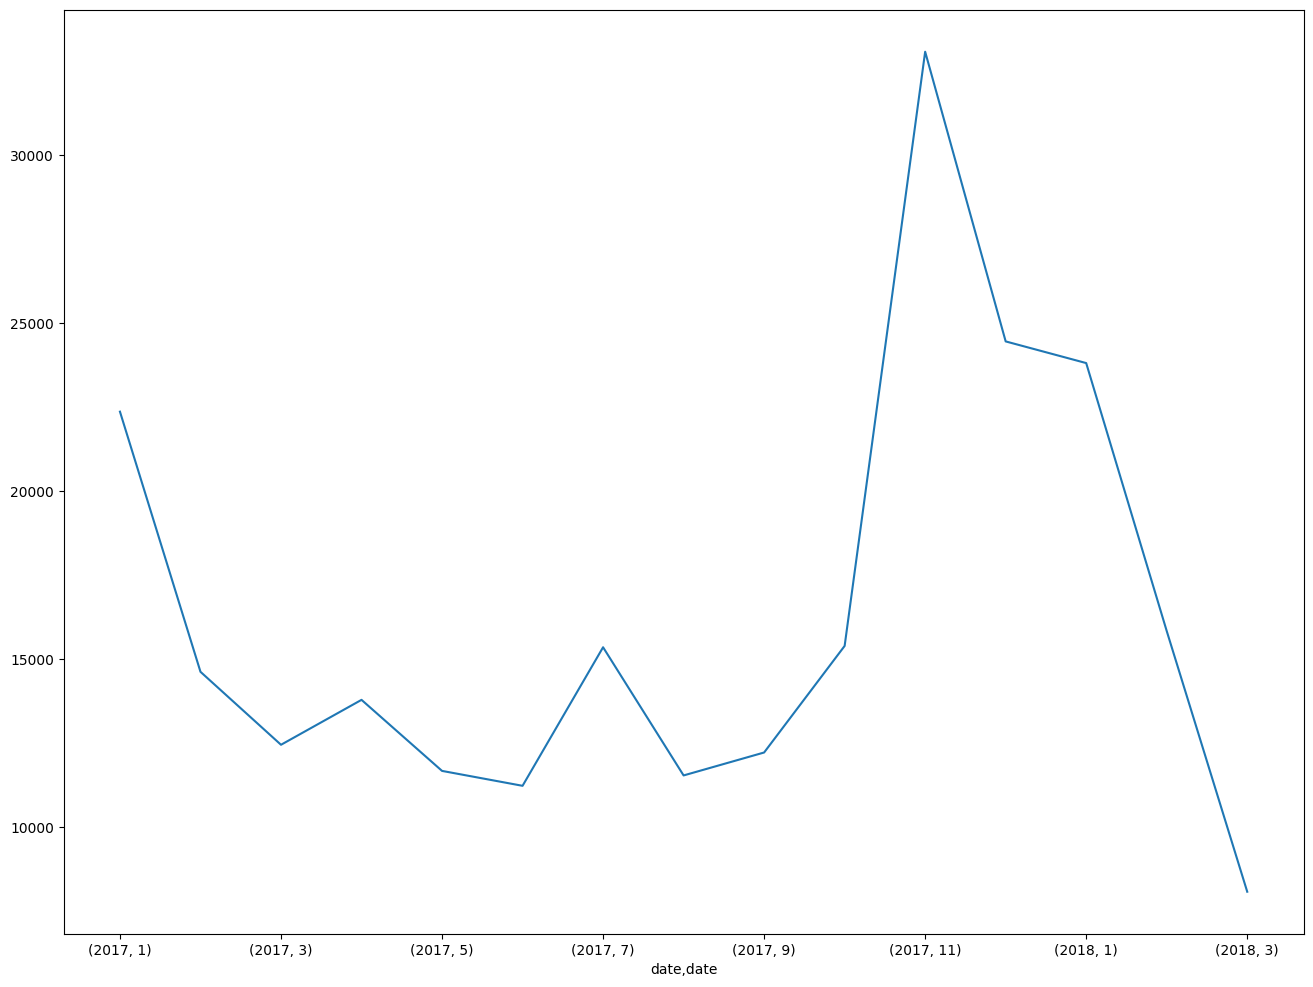

In [15]:
(
    ol_df.groupby([ol_df["date"].dt.year,
                   ol_df["date"].dt.month])["product_quantity"]
    .sum()
    .plot(figsize=(16, 12))
);

## 3.&nbsp; `.resample()`

Resampling allows us to easily aggregate time series data. When using `.resample()`, we have to define:
- The frequency of time for which to group the data (e.g. 5 minutely, hourly, daily...) expressed as a "frequency string" (`"W"` for weekly, `"ME"` for month end...). Find all available frequency strings [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects).
- The column with the dates group by needs to be passed to the `on` parameter (unless you want group by the index).
- The aggregate function (`sum()`, `count()`, `mean()`...)
- The numerical column/s to aggregate.

With this we can easily recreate our groupby above, where we looked at the amount of products sold each month. The date displayed is the last day of the given month.

In [16]:
(
    ol_df
    .resample("ME", on="date")["product_quantity"]
    .sum()
    .sort_values(ascending=False)
)

,product_quantity
date,
2017-11-30,33082
2017-12-31,24455
2018-01-31,23810
2017-01-31,22363
2018-02-28,15831
2017-10-31,15387
2017-07-31,15347
2017-02-28,14616
2017-04-30,13781


We can also quickly plot a daily graph for the amount of products sold.

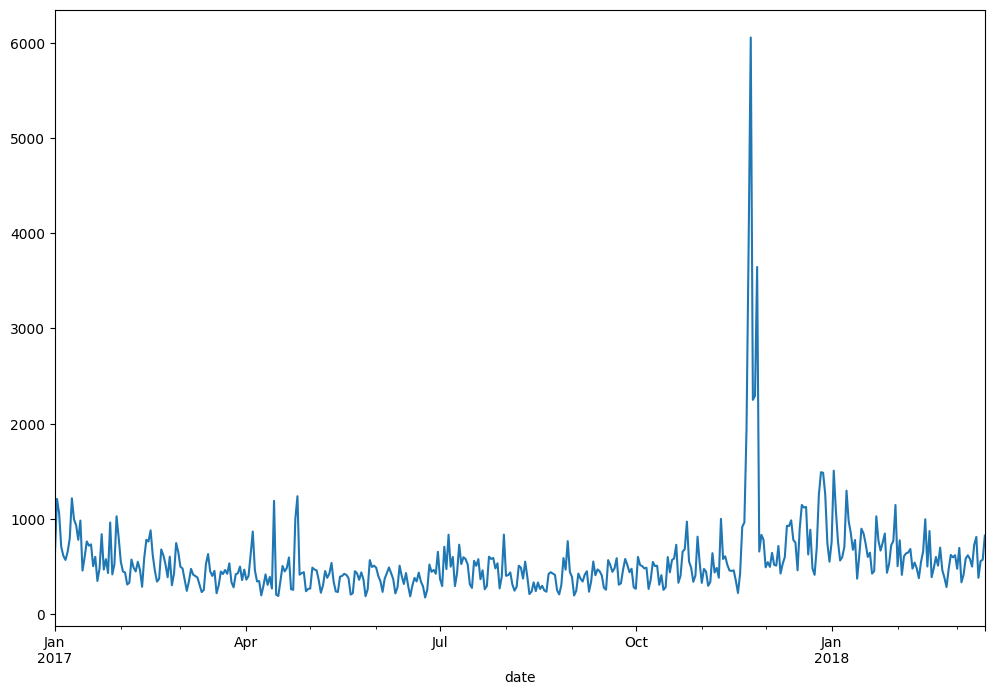

In [17]:
(
    ol_df
    .resample("D", on="date")
    .sum()["product_quantity"]
    .plot(figsize=(12, 8))
 );

We can create the same graph as above using `.groupby()`, it just takes a little more code

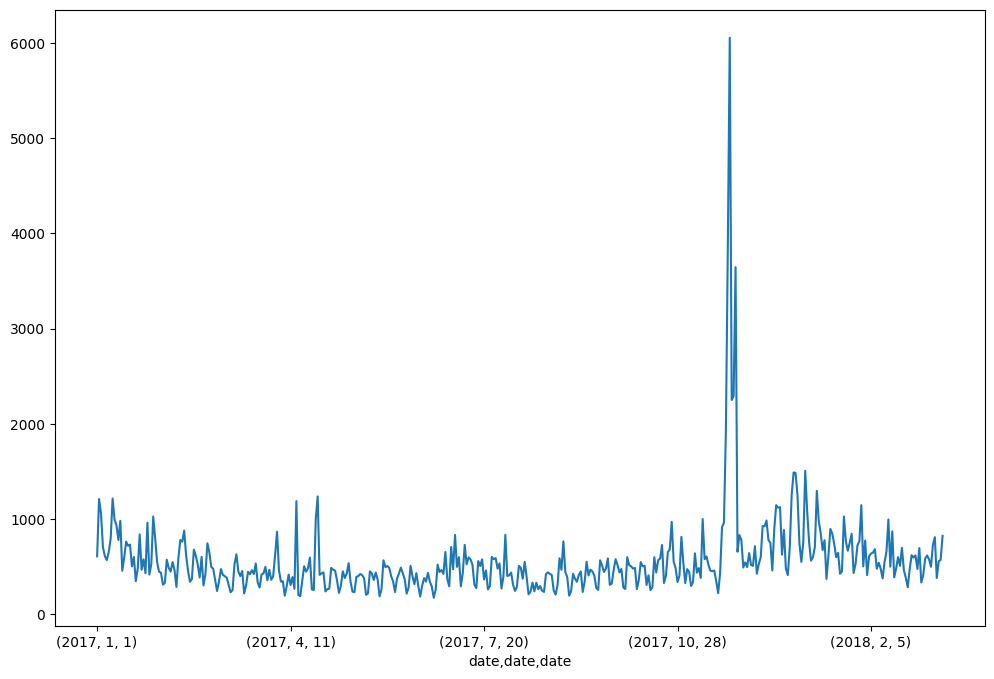

In [18]:
(
    ol_df
    .groupby([ol_df.date.dt.year,
              ol_df.date.dt.month,
              ol_df.date.dt.day])["product_quantity"]
    .sum()
    .plot(figsize=(12, 8))
 );

As you can see from the x-axis of the two charts above, `.resample()` works a little more inuitvely when you want to group by datetimes. This isn't to say that you cannot use `.groupby()` with datetimes, of course you can. `.resample()` just provides us with a little extra flexibility to group datetime by specific groups. For example, you can create `.resample()` input strings such as `2H20min` for groups of 2 hours 20minutes, `3min` for groups of 3 minutes, `1D3H` for 1 day 3hours etc...

# Challenges

## Challenge 1. What are the top 8 most sold products?

In [19]:
# your code here

## Challenge 2. How many products did each of the 5 largest orders contain?

In [20]:
# your code here

## Challenge 3. We want to see how busy the days of the week are to know when we need more staff. Rank the days of the week from busiest to least busy.
Bonus points for using your pandas plotting skills.

In [21]:
# your code here

## Challenge 4. Which brands sell the most products?

In [22]:
# your code here

## Challenge 5. Plot a line chart for the amount of orders each hour of November 2017

In [23]:
# your code here